In [14]:
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter


import sys
sys.path.append('../')
sys.path.append('../phase')
from phase.input_output import PhaseData
from phase.qc import OutlierDetector

In [27]:
data_dir = '../../DATA/ancestry'
#data_dir = '../../DATA/ssc.hg38'
#data_dir = '../../DATA/platinum_sim'
#phase_name = 'X'
phase_name = None
#phase_name = 'noDEL'

colors = ['#4db6acff', '#ef6c00ff', '#b3a77dff', '#695d46ff', '#ce93d8ff', '#009668ff', ]

In [28]:
phase_data = PhaseData(data_dir, phase_name)
sibpairs = phase_data.get_sibpairs()
print('sibpairs', len(sibpairs))

crossovers = phase_data.get_crossovers()
print('crossovers', len(crossovers))

sibpairs 298
crossovers 48613


In [29]:
crossover_lengths = np.array([co['end_pos']-co['start_pos'] for co in crossovers])
is_mat = np.array([co['is_mat'] for co in crossovers])
is_hts = np.array([co['is_hts'] for co in crossovers])

In [30]:
mat_crossovers = np.array([x['maternal_crossovers'] for x in sibpairs if x['is_fully_phased']])
pat_crossovers = np.array([x['paternal_crossovers'] for x in sibpairs if x['is_fully_phased']])

is_ibd_outlier = np.array([x['is_ibd_outlier'] for x in sibpairs if x['is_fully_phased']], dtype=bool)
is_outlier = np.array([x['is_crossover_outlier'] for x in sibpairs if x['is_fully_phased']], dtype=bool)

print('outliers', np.sum(is_outlier))

x_min, x_max = np.min(mat_crossovers[~is_ibd_outlier])-5, np.max(mat_crossovers[~is_ibd_outlier])+5
y_min, y_max = np.min(pat_crossovers[~is_ibd_outlier])-5, np.max(pat_crossovers[~is_ibd_outlier])+5


outliers 26


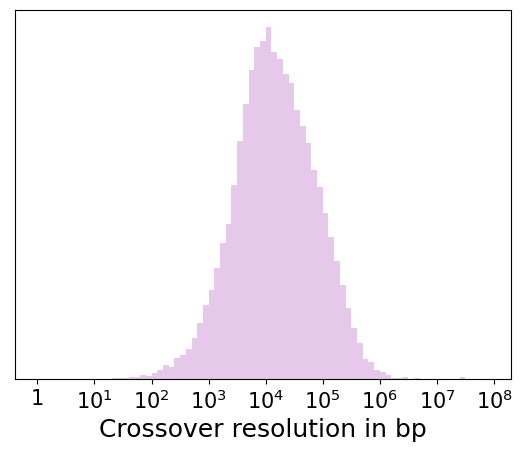

In [31]:
plt.hist(np.log10(crossover_lengths), 
         alpha=0.5, bins=np.arange(0, 8, 0.1), color=colors[4])
plt.hist(np.log10(crossover_lengths[is_hts & is_mat]), 
         alpha=0.5, bins=np.arange(0, 8, 0.1))
plt.hist(np.log10(crossover_lengths[is_hts & ~is_mat]), 
         alpha=0.5, bins=np.arange(0, 8, 0.1))

plt.xlabel('Crossover resolution in bp', fontsize=18)
plt.xticks(np.arange(0, 9), ['1' if i==0 else '$10^{%d}$' % i for i in np.arange(0, 9)], fontsize=15)
plt.yticks([])
plt.show()

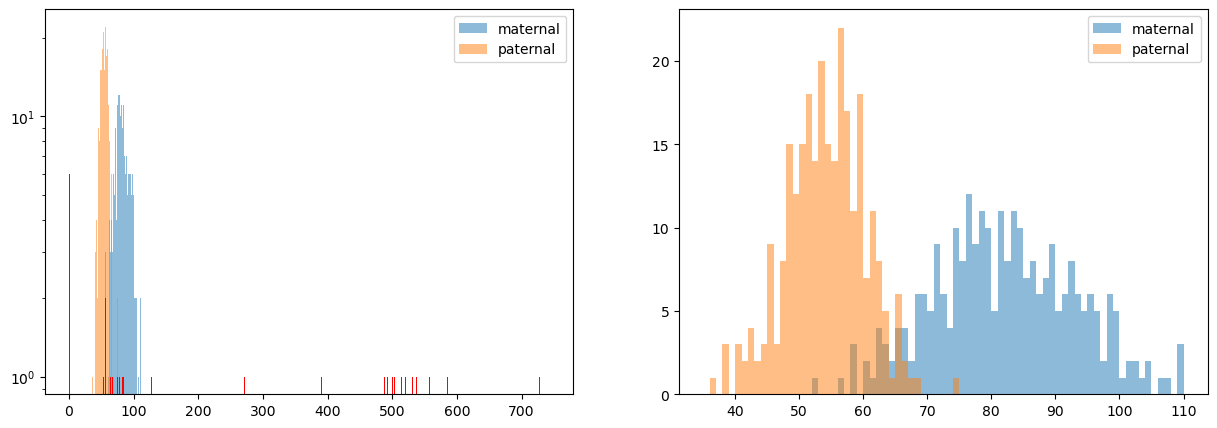

In [32]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(mat_crossovers, bins=np.arange(max(x_max, y_max)), alpha=0.5, label='maternal', log=True)
plt.hist(pat_crossovers, bins=np.arange(max(x_max, y_max)), alpha=0.5, label='paternal', log=True)
plt.hist(mat_crossovers[is_outlier], bins=np.arange(max(x_max, y_max)), color='red', log=True)
plt.hist(pat_crossovers[is_outlier], bins=np.arange(max(x_max, y_max)), color='red', log=True)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(mat_crossovers[~is_outlier], bins=np.arange(np.min(pat_crossovers[~is_outlier])-1, np.max(mat_crossovers[~is_outlier])+1), 
         alpha=0.5, label='maternal')
plt.hist(pat_crossovers[~is_outlier], bins=np.arange(np.min(pat_crossovers[~is_outlier])-1, np.max(mat_crossovers[~is_outlier])+1), 
         alpha=0.5, label='paternal')
plt.legend()
plt.show()

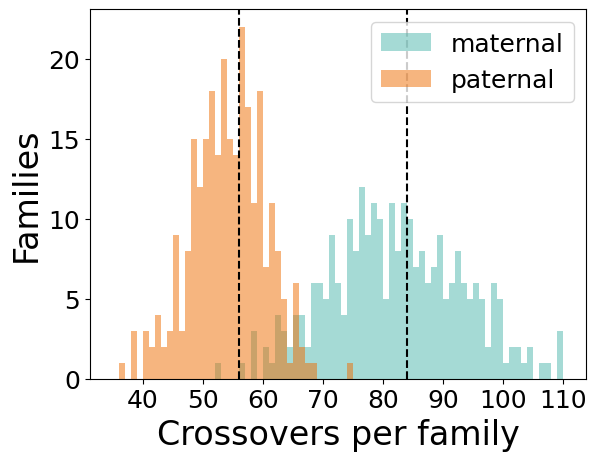

In [33]:
plt.hist(mat_crossovers[~is_outlier], bins=np.arange(np.min(pat_crossovers[~is_outlier])-1, np.max(mat_crossovers[~is_outlier])+1, 1), 
         alpha=0.5, label='maternal', color=colors[0])
plt.hist(pat_crossovers[~is_outlier], bins=np.arange(np.min(pat_crossovers[~is_outlier])-1, np.max(mat_crossovers[~is_outlier])+1, 1), 
         alpha=0.5, label='paternal', color=colors[1])
plt.legend(fontsize=18)
plt.xlabel('Crossovers per family', fontsize=24)
plt.xticks(fontsize=18)
plt.ylabel('Families', fontsize=24)
plt.yticks(fontsize=18)

if phase_name is None:
    plt.axvline(84, color='black', linestyle='--')
    plt.axvline(56, color='black', linestyle='--')

#plt.savefig('../plots/crossover_count.png', bbox_inches="tight")
#plt.savefig('../plots/Fig_4.png', bbox_inches="tight")

In [34]:
print(np.median(mat_crossovers[~is_outlier]))
print(np.median(pat_crossovers[~is_outlier]))

print(np.mean(mat_crossovers[~is_outlier]))
print(np.mean(pat_crossovers[~is_outlier]))

81.0
54.0
81.55147058823529
53.67279411764706


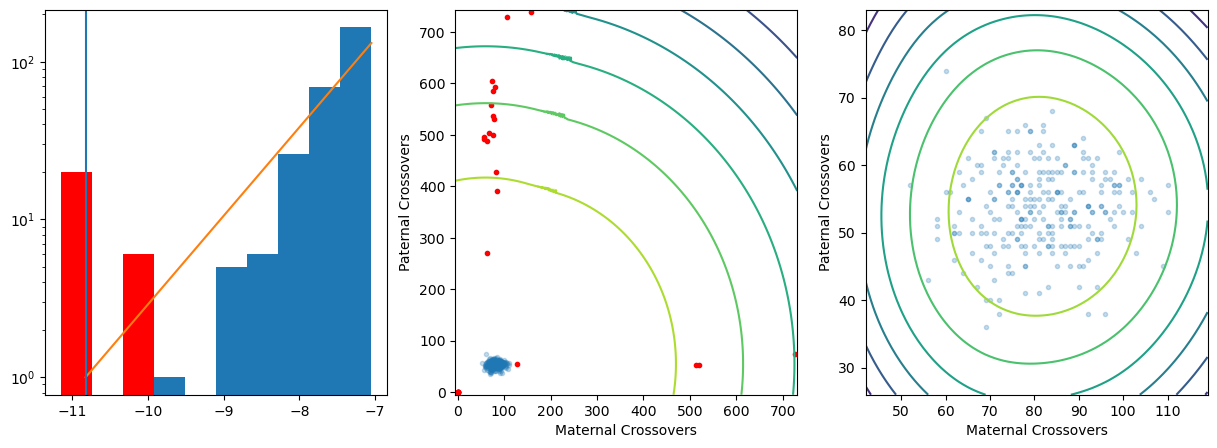

In [35]:
is_way_out = (mat_crossovers > 3*np.median(mat_crossovers)) | (pat_crossovers > 3*np.median(pat_crossovers))
detector = OutlierDetector(mat_crossovers[~is_ibd_outlier & ~is_way_out], 
                           pat_crossovers[~is_ibd_outlier & ~is_way_out], 10)
scores = detector.score_samples(mat_crossovers, pat_crossovers)
outlier_cutoff, m, b = detector.outlier_cutoff, detector.m, detector.b
bins = detector.bins

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(np.clip(scores, min(bins[0], outlier_cutoff), bins[-1]), bins=bins, log=True)
plt.hist(np.clip(scores[is_outlier], min(bins[0], outlier_cutoff), bins[-1]), bins=bins, log=True, color='red')
plt.plot([outlier_cutoff, bins[-1]], [np.exp(m*outlier_cutoff+b), np.exp(m*bins[-1]+b)])
plt.axvline(outlier_cutoff)

plt.subplot(1, 3, 2)
xintervals = np.arange(x_min, x_max)
yintervals = np.arange(y_min, y_max)
gridx, gridy = np.meshgrid(xintervals, yintervals)
predict = detector.score_samples(gridx.flatten(), gridy.flatten())
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))

plt.scatter(mat_crossovers, pat_crossovers, marker='.', alpha=0.25)
plt.scatter(mat_crossovers[is_outlier], pat_crossovers[is_outlier], marker='.', color='red')
plt.xlabel('Maternal Crossovers')
plt.ylabel('Paternal Crossovers')

plt.subplot(1, 3, 3)
xintervals = np.arange(np.min(mat_crossovers[~is_outlier])-10, np.max(mat_crossovers[~is_outlier])+10)
yintervals = np.arange(np.min(pat_crossovers[~is_outlier])-10, np.max(pat_crossovers[~is_outlier])+10)
gridx, gridy = np.meshgrid(xintervals, yintervals)
predict = detector.score_samples(gridx.flatten(), gridy.flatten())
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))

plt.scatter(mat_crossovers[~is_outlier], pat_crossovers[~is_outlier], marker='.', alpha=0.25)
plt.xlabel('Maternal Crossovers')
plt.ylabel('Paternal Crossovers')

plt.show()

In [36]:
print(mat_crossovers[is_outlier])
print(pat_crossovers[is_outlier])
print(scores[is_outlier])

[127  64  56  78  56  67  82  84 727   0   0  63  77   0   0   0 157  77
 520 514   0  72  77 106  74  80]
[ 55 271 496 531 492 503 428 390  74   0   0 487 500   0   0   0 739 537
  53  52   0 557 585 728 604 592]
[  -11.15101711  -206.19925726  -902.57425903 -1057.93925903
  -885.77425903  -932.52425903  -641.07425903  -514.23425895
 -1813.87925903   -10.28249956   -10.28249956  -864.96425903
  -920.89925903   -10.28249956   -10.28249956   -10.28249956
 -2270.24425903 -1085.36425903  -784.33925903  -760.96425903
   -10.28249956 -1179.23925903 -1319.12425903 -2161.23425903
 -1417.55425903 -1355.69425903]


In [37]:
print(np.max(mat_crossovers[~is_outlier]))

110


In [38]:
print(Counter([x['chrom'] for x in crossovers if x['is_hts']]))

Counter()
